# Screening case studies

In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from zeobind.src.utils.utils import setup_mpl, save_mpl_fig, format_axs, get_cb, get_legend, get_competition
setup_mpl() 
import warnings
warnings.filterwarnings('ignore')

# Plotting functions

In [2]:
def plot_mols(ss, legend, n_cols=5, img_size=(200, 200)):
    # Convert SMILES strings to RDKit molecule objects
    mols = [Chem.MolFromSmiles(s) for s in ss]

    # Define subplot dimensions
    n_mols = len(mols)
    n_cols = n_cols  # Number of columns in the subplot grid
    n_rows = n_mols // n_cols + (n_mols % n_cols > 0)  # Calculate rows needed

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 3))  # Adjust figure size as needed

    # Flatten the axs array for easy indexing
    axs = axs.flatten()

    for i, mol in enumerate(mols):
        # Generate molecule image
        img = Draw.MolToImage(mol, size=img_size)  # Adjust image size as needed
        
        # Plot the image
        axs[i].imshow(img)

        # Hide the spines
        for spine in axs[i].spines.values():
            spine.set_visible(False)

        # Hide all y-axis related elements
        axs[i].get_yaxis().set_visible(False)

        # Set the x-axis label with the molecule label and other metrics
        axs[i].set_xlabel(legend[i], rotation=0, labelpad=2, verticalalignment='center', fontsize=15)

        # Hide x-axis ticks 
        axs[i].set_xticks([])
        axs[i].set_xticklabels([])

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    plt.tight_layout()
    return fig, axs

# Read project files

In [3]:
# main dir
screening_op_dir = "../../data/publication/screening/"
figure_op_dir = f"{screening_op_dir}/figures"
os.makedirs(figure_op_dir, exist_ok=True)

In [4]:
# training data
truth = pd.read_csv("../../data/datasets/training_data/training_data.csv", index_col=0)

In [5]:
# predictions of training data 
truth_preds_dir = "../../data/predictions/training_data/"
truth_mean = glob.glob(truth_preds_dir + "formatted_be/*mean*.csv")
truth_mean = pd.concat([pd.read_csv(f, index_col=0) for f in truth_mean])
truth_mean.drop_duplicates(inplace=True)
truth_mean = truth_mean.unstack()
truth_mean = truth_mean.loc[truth.set_index(['Zeolite', 'SMILES']).index].reset_index()
truth_mean = truth_mean.rename(columns={'level_0': 'Zeolite', 0: 'BE (mean)'})

truth_std = glob.glob(truth_preds_dir + "formatted_be/*std*.csv")
truth_std = pd.concat([pd.read_csv(f, index_col=0) for f in truth_std])
truth_std.drop_duplicates(inplace=True)
truth_std = truth_std.unstack()
truth_std = truth_std.loc[truth.set_index(['Zeolite', 'SMILES']).index].reset_index()
truth_std = truth_std.rename(columns={'level_0': 'Zeolite'})

truth_mclass_preds = pd.read_csv(f"{truth_preds_dir}/mclass/condensed/osda_priors_0_zeolite_priors_0_preds.csv")

truth_mclass_preds = truth_mclass_preds.set_index(['Zeolite', 'SMILES']).loc[truth.set_index(['Zeolite', 'SMILES']).index].reset_index()

In [6]:
# training data molecule features
truth_opriors = pd.read_pickle("../../data/datasets/training_data/osda_priors_0.pkl")

In [7]:
# zeolite features 
zpriors = pd.read_pickle("../../data/datasets/training_data/zeolite_priors_0.pkl")

In [8]:
# force field energies of selected molecules
ff_file = "../../data/publication/screening/ff_energies.csv"
ff_df = pd.read_csv(ff_file, index_col=0)

In [9]:
# features of selected molecules
ff_opriors = pd.read_pickle("../../data/publication/screening/osda_priors_0.pkl")

# ERI case study

In [10]:
chevron_monoquat = 'c1c[n+](C2CCCCC2)cn1C1CCCCC1' 

In [11]:
fw = 'ERI'
final_pool_dir = f"{screening_op_dir}/{fw}"
eri_data = pd.read_csv(f"{final_pool_dir}/{fw}_all.csv", index_col=0)

- First we look at the ML predicted energetics

['ML BE: -13.04\nML CE: 0.32', 'ML BE: -12.39\nML CE: 0.5', 'ML BE: -12.34\nML CE: 0.31', 'ML BE: -12.04\nML CE: 0.31', 'ML BE: -12.0\nML CE: 0.31', 'ML BE: -11.88\nML CE: 0.2', 'ML BE: -11.85\nML CE: 0.35', 'ML BE: -11.72\nML CE: 0.27', 'ML BE: -11.63\nML CE: 0.36', 'ML BE: -11.6\nML CE: 0.25', 'ML BE: -11.51\nML CE: 0.38', 'ML BE: -11.1\nML CE: 0.28']


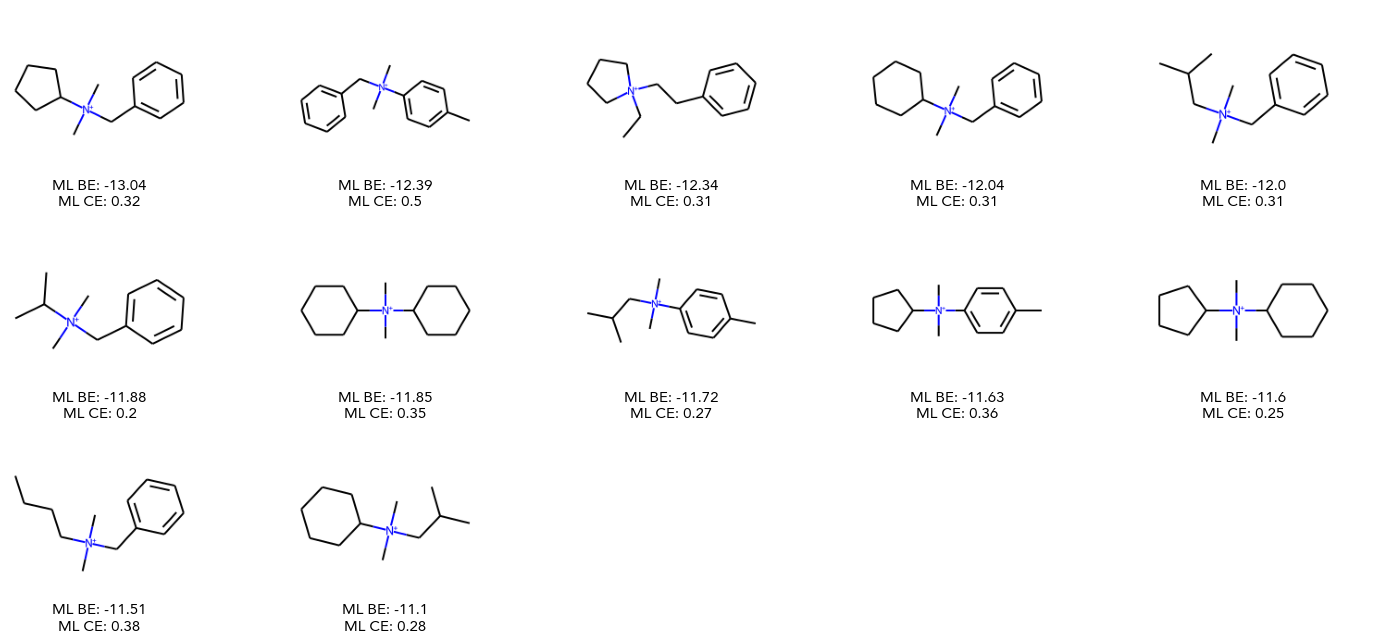

In [12]:
eri_data = eri_data.sort_values(['be', 'ce'])
l = list(zip(
    [round(x,2) for x in eri_data['be']],
    [round(x,2) for x in eri_data['ce']],
))
l = [f"ML BE: {x[0]}\nML CE: {x[1]}" for x in l]
print(l)
fig, axs = plot_mols(eri_data.index, n_cols=5, legend=l)

- Then we examine the force field energetics

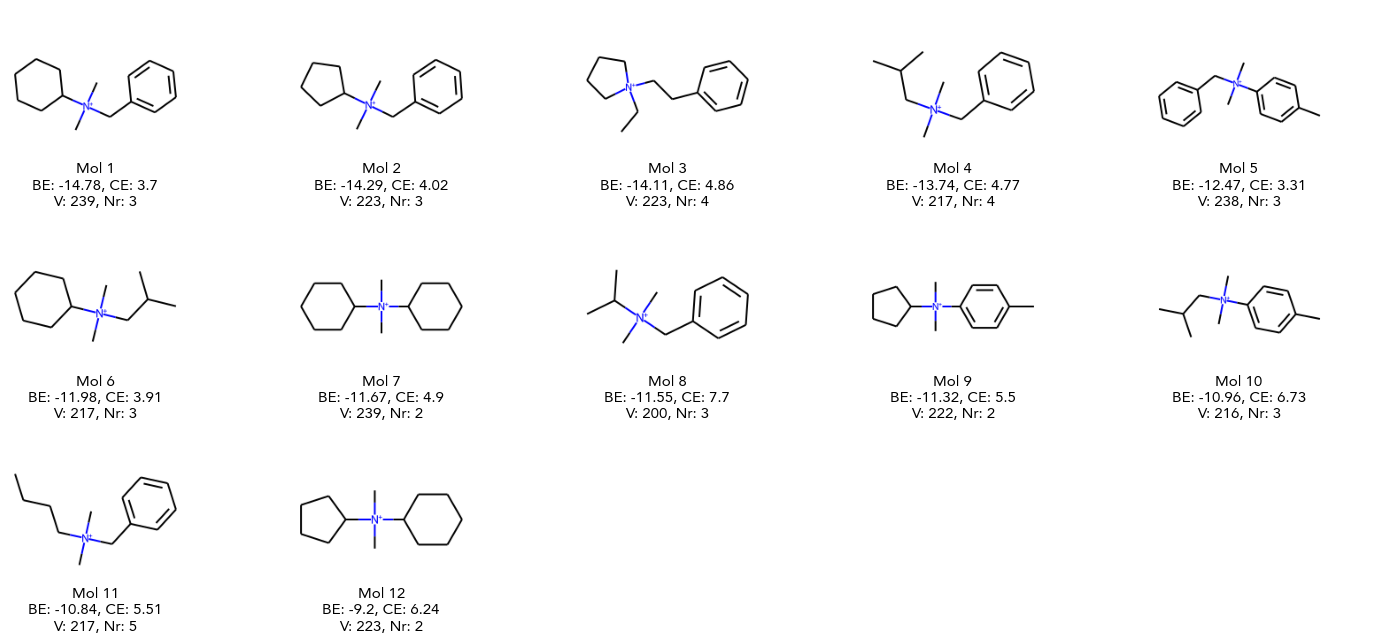

In [13]:
ff_eri = ff_df[ff_df['SMILES'].isin(eri_data.index)]
ff_eri_mat = ff_eri.pivot(index='SMILES', columns='Zeolite', values='Binding (SiO2)')
ff_eri_comp_mat = get_competition(ff_eri_mat)

# sort values by BE 
ss = ff_eri_mat.sort_values(fw).index 

labels = [f"Mol {i+1}" for i in range(len(ss))]
ee = ff_eri_mat.loc[ss][fw]
cc = ff_eri_comp_mat.loc[ss][fw]
vv = eri_data.loc[ss]['mol_volume']
nn = eri_data.loc[ss]['num_rot_bonds']
ll = [f"{l}\nBE: {round(x,2)}, CE: {round(c,2)}\nV: {round(v)}, Nr: {n}" for l, x, c, v, n in zip(labels, ee, cc, vv, nn)]

fig, axs = plot_mols(ss, legend=ll, n_cols=5)

- We can plot all the *predicted* energies on a BE-molecular volume plot

In [14]:
# Read data files containing < -8 kJ/ mol Si, < 24 heavy atoms.
initial_filters = "strong_be_ce"

eri_all_mean = pd.read_csv(screening_op_dir + f'/{initial_filters}/eri/eri_means.csv', index_col=0)
eri_all_oprior = pd.read_pickle(screening_op_dir + f'/{initial_filters}/eri/eri_opriors.pkl')
eri_all_comp = pd.read_csv(screening_op_dir + f'/{initial_filters}/eri/eri_comp.csv', index_col=0)

print(f"{eri_all_mean.shape[0]} molecules with BE < -8 kJ/ mol Si")

99084 molecules with BE < -8 kJ/ mol Si


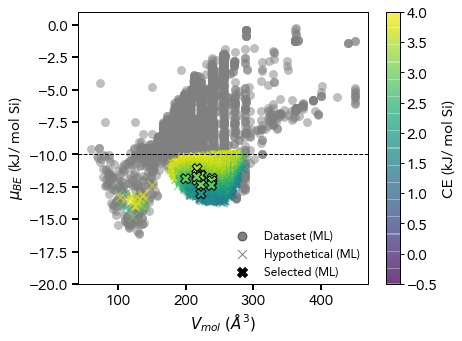

In [15]:
fig, axs = plt.subplots(figsize=(6.5, 5))
fw = 'ERI'

# background is project dataset 
y_bg = truth_mean[truth_mean['Zeolite'] == fw].set_index('SMILES')['BE (mean)']
y_bg = y_bg[y_bg.lt(0.0)] # only plot binding for clarity
x_bg = truth_opriors.loc[y_bg.index]['mol_volume']
kwargs = dict(marker='o', s=80, alpha=0.5, color='grey', label='Dataset (ML)', rasterized=True, linewidth=0)
sc = axs.scatter(x_bg, y_bg, **kwargs)

# foreground is selected dataset 
y_fg = eri_all_mean[fw]
y_fg = y_fg[y_fg <= -10.0]
y_fg = y_fg[eri_all_comp.loc[y_fg.index][fw] <= 4.0] 
y_fg = y_fg.sort_values(ascending=False)
x_fg = eri_all_oprior.loc[y_fg.index]['mol_volume']
c = eri_all_comp.loc[y_fg.index][fw]
kwargs = dict(marker='x', s=80, alpha=0.5, c=c, label='Hypothetical (ML)', rasterized=True, 
              vmin=-0.5, vmax=4, cmap='viridis')
sc = axs.scatter(x_fg, y_fg, **kwargs)

axs = format_axs(axs, 15, 15, 1, "$V_{mol} \; (\AA^3)$", "$\mu_{BE}$ (kJ/ mol Si)", 15, 15)
cb = get_cb(fig, sc, axs, "CE (kJ/ mol Si)", ticks=None, linewidth=1, tickwidth=1, labelsize=15, labelpad=20)

# horizontal line at -10
axs.axhline(-10, color='k', linestyle='--', linewidth=1, rasterized=True);

# plot ML energies for final pool of selected molecules
ee = eri_all_mean[fw].reindex(ff_eri_mat.index)
cc = eri_all_comp[fw].reindex(ff_eri_mat.index)
vv = eri_all_oprior['mol_volume'].reindex(ff_eri_mat.index)
axs.scatter(vv.values, ee.values, c=cc.values, marker='X', s=100, edgecolors=['k', 'k'], linewidth=1, label="Selected (ML)",
            vmin=-0.5, vmax=4, cmap='viridis')

# get legend
leg = get_legend(fig, bbox_to_anchor=(0.75, 0.11), fontsize=12, loc="lower right", ncol=1, axs=axs, format_handles=True,legend_colors=['black', 'black', 'black', 'black'], linewidth=1)
leg.labelspacing = 0.0

axs.set_ylim([-20, 1])

save_mpl_fig(fig, figure_op_dir + "/be_vol_eri", ".pdf")
save_mpl_fig(fig, figure_op_dir + "/be_vol_eri", ".svg")

## ERI family of monoquat

In [16]:
with open(screening_op_dir + f"{fw}/eri_monoquat_family.txt", "r") as f:
    eri_family = f.readlines()
eri_family = [s.strip() for s in eri_family]

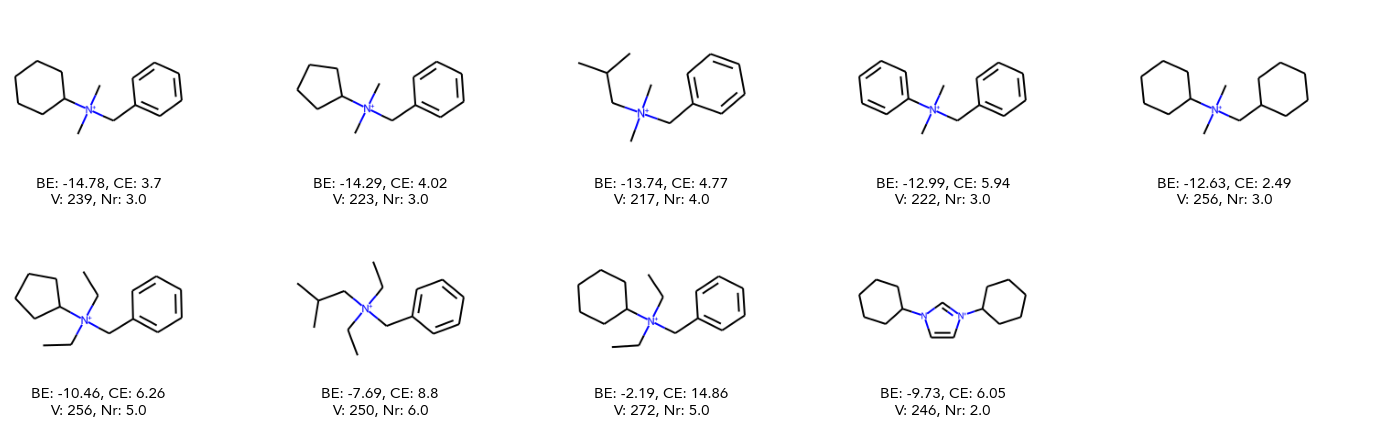

In [17]:
eri_1_fam_df = ff_df[ff_df['SMILES'].isin(eri_family)]

eri_1_fam_mat = eri_1_fam_df.pivot(index='SMILES', columns='Zeolite', values='Binding (SiO2)')
eri_1_fam_mat_comp = get_competition(eri_1_fam_mat)

eri_1_fam_mat = eri_1_fam_mat.sort_values('ERI')
ss = eri_1_fam_mat.index.tolist()

# move chevron_monoquat to the end of the list 
ss.remove(chevron_monoquat); ss.append(chevron_monoquat)

ee = eri_1_fam_mat['ERI']
cc = eri_1_fam_mat_comp.loc[ss]['ERI']

nan_fws = [str(eri_1_fam_mat_comp.columns[eri_1_fam_mat_comp.loc[s].isna()].to_list()) for s in ss]
nan_fws = pd.DataFrame(nan_fws, index=ss)

vv = ff_opriors.loc[ss]['mol_volume']
nn = ff_opriors.loc[ss]['num_rot_bonds']

ll = [f"BE: {round(ee.loc[s], 2)}, CE: {round(cc.loc[s], 2)}\nV: {round(vv.loc[s])}, Nr: {nn.loc[s]}" for s in ss]
fig, axs = plot_mols(ss, ll) 

# CHA case study 

In [18]:
fw = 'CHA'
final_pool_dir = f"{screening_op_dir}/{fw}"
cha_data = pd.read_csv(f"{final_pool_dir}/{fw}_all.csv", index_col=0)
cha_data = cha_data.sort_values(['be', 'ce'])

- First we look at the ML predicted energetics

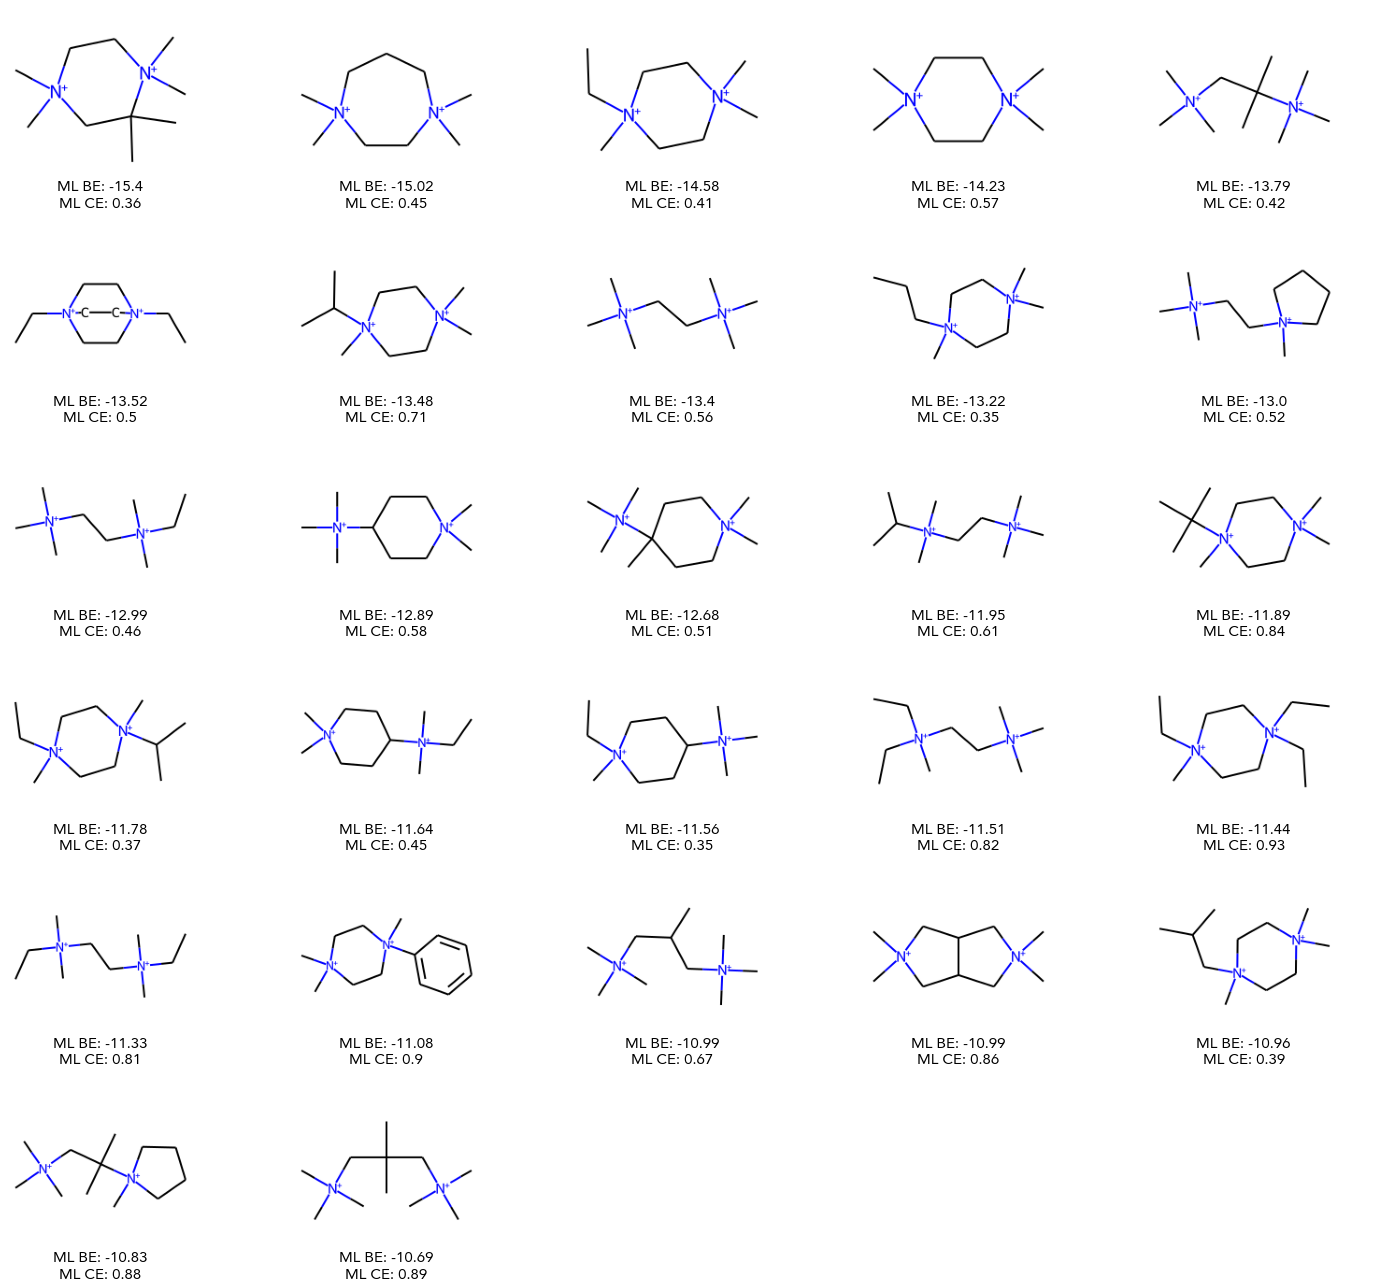

In [19]:
l = list(zip(
    [round(x,2) for x in cha_data['be']],
    [round(x,2) for x in cha_data['ce']],
))
l = [f"ML BE: {x[0]}\nML CE: {x[1]}" for x in l]
fig, axs = plot_mols(cha_data.index, n_cols=5, legend=l)

- Then we examine the force field energetics

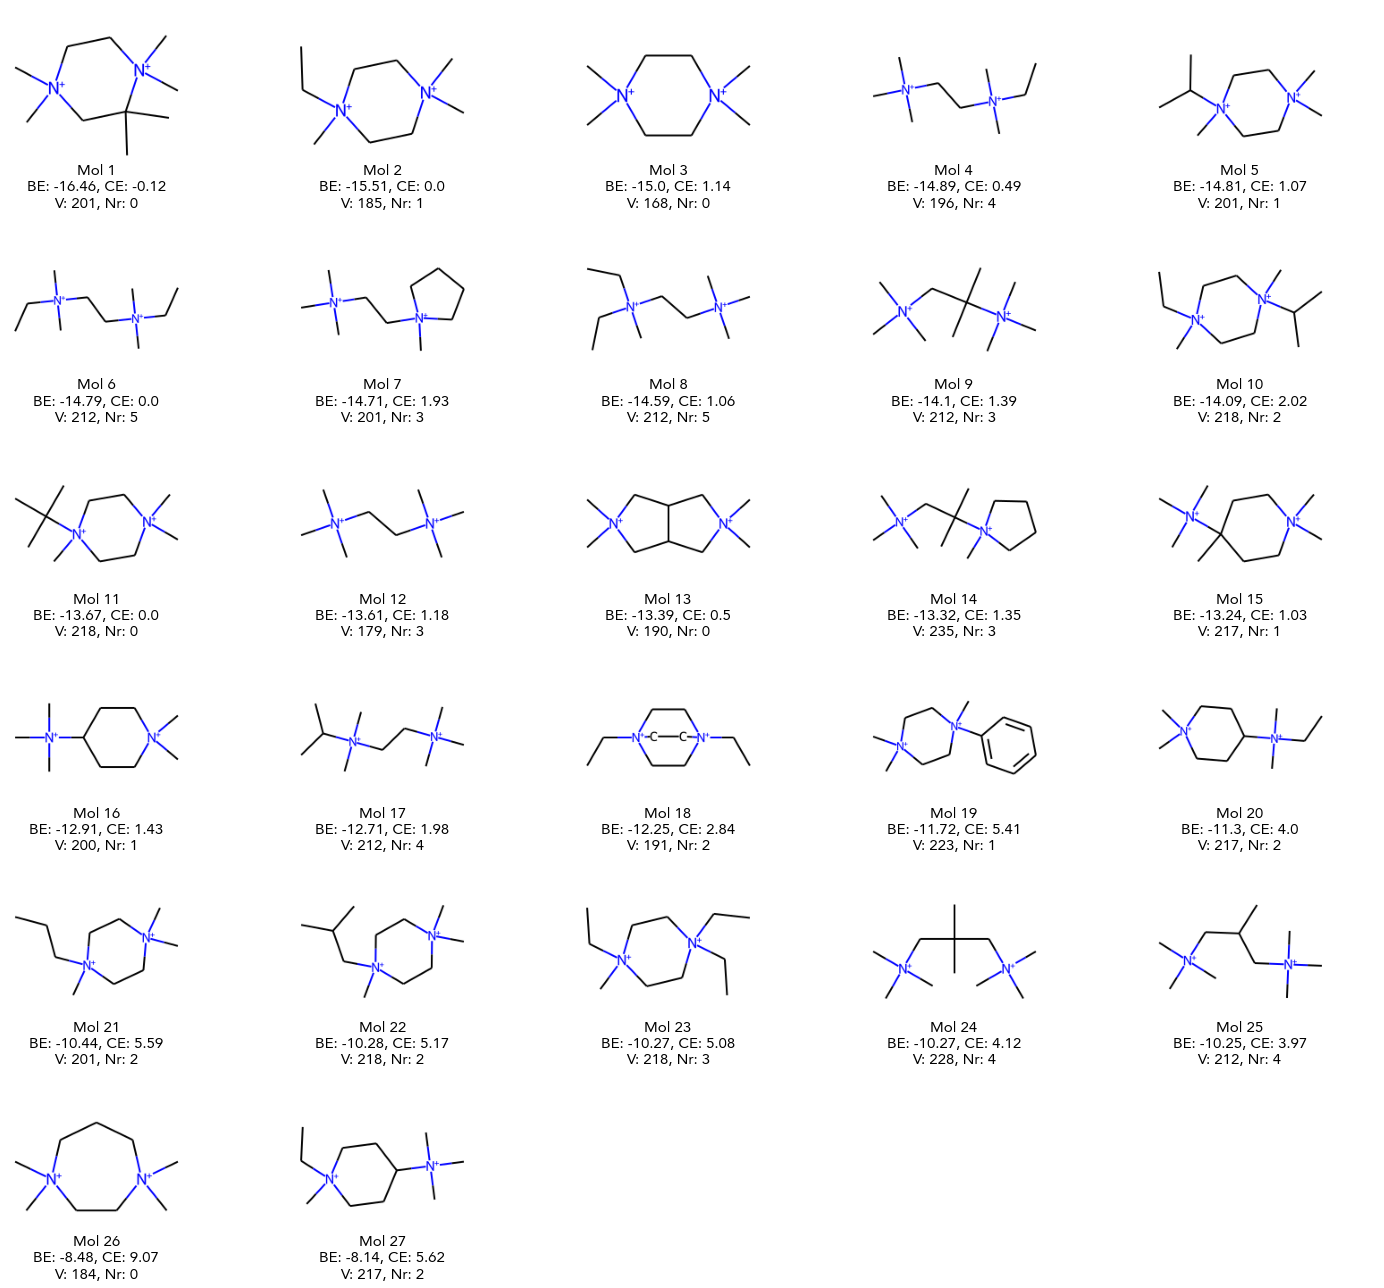

In [20]:
ff_cha = ff_df[ff_df['SMILES'].isin(cha_data.index)]
ff_cha_mat = ff_cha.pivot(index='SMILES', columns='Zeolite', values='Binding (SiO2)')
ff_cha_comp_mat = get_competition(ff_cha_mat)

# sort values by BE 
ss = ff_cha_mat.sort_values(fw).index 

labels = [f"Mol {i+1}" for i in range(len(ss))]
ee = ff_cha_mat.loc[ss][fw]
cc = ff_cha_comp_mat.loc[ss][fw]
vv = cha_data.loc[ss]['mol_volume']
nn = cha_data.loc[ss]['num_rot_bonds']
ll = [f"{l}\nBE: {round(x,2)}, CE: {round(c,2)}\nV: {round(v)}, Nr: {n}" for l, x, c, v, n in zip(labels, ee, cc, vv, nn)]

fig, axs = plot_mols(ss, legend=ll, n_cols=5)

## CHA family of bicyclic diquat

In [21]:
with open(screening_op_dir + f"{fw}/cha_bicyclic_family.txt", "r") as f:
    cha_1_family = f.readlines()
cha_1_family = [s.strip() for s in cha_1_family]

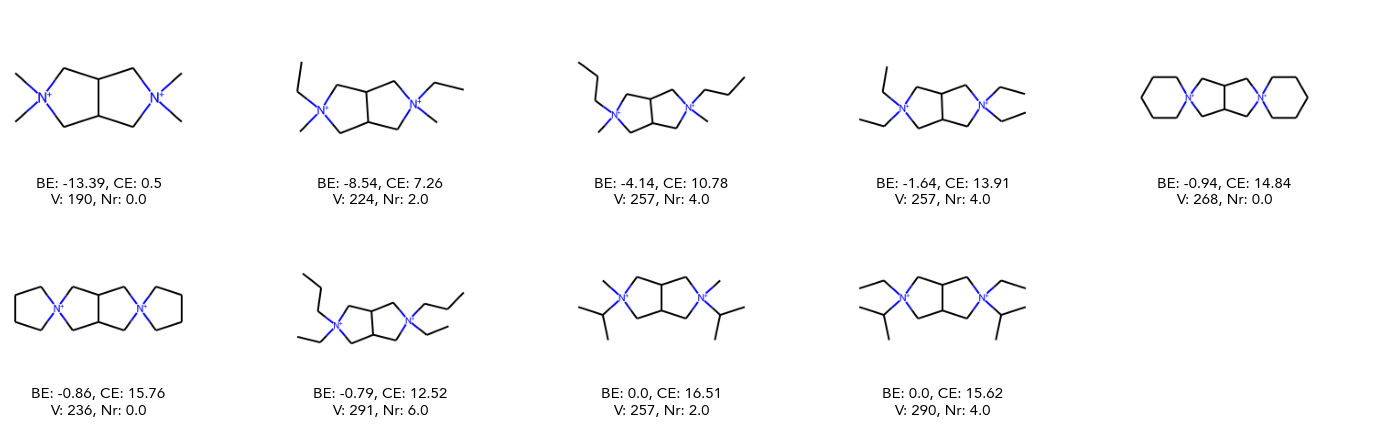

In [22]:
cha_1_fam_df = ff_df[ff_df['SMILES'].isin(cha_1_family)]

cha_1_fam_mat = cha_1_fam_df.pivot(index='SMILES', columns='Zeolite', values='Binding (SiO2)')
cha_1_fam_mat_comp = get_competition(cha_1_fam_mat)

cha_1_fam_mat = cha_1_fam_mat.sort_values('CHA')
ss = cha_1_fam_mat.index
ee = cha_1_fam_mat['CHA']
cc = cha_1_fam_mat_comp.loc[ss]['CHA']

nan_fws = [str(cha_1_fam_mat_comp.columns[cha_1_fam_mat_comp.loc[s].isna()].to_list()) for s in ss]
nan_fws = pd.DataFrame(nan_fws, index=ss)

vv = ff_opriors.loc[ss]['mol_volume']
nn = ff_opriors.loc[ss]['num_rot_bonds']

ll = [f"BE: {round(ee.loc[s], 2)}, CE: {round(cc.loc[s], 2)}\nV: {round(vv.loc[s])}, Nr: {nn.loc[s]}" for s in ss]
fig, axs = plot_mols(ss, ll) 

- We can plot all the *predicted* energies on a BE-molecular volume plot

In [23]:
# Read data file containing < -8 kJ/ mol Si, < 24 heavy atoms - 15 seconds

cha_all_mean = pd.read_csv(screening_op_dir + f'/{initial_filters}/cha/cha_means.csv', index_col=0)
# cha_all_std = pd.read_csv(screening_op_dir + f'/{initial_filters}/cha/cha_stds.csv', index_col=0)
cha_all_oprior = pd.read_pickle(screening_op_dir + f'/{initial_filters}/cha/cha_opriors.pkl')
cha_all_comp = pd.read_csv(screening_op_dir + f'/{initial_filters}/cha/cha_comp.csv', index_col=0)
# cha_all_info = pd.read_csv(screening_op_dir + f'/{initial_filters}/cha/cha_info.csv', index_col=0)
# cha_all_load_mean = pd.read_csv(screening_op_dir + f'/{initial_filters}/cha/cha_load_mean.csv', index_col=0)

print(f"{cha_all_mean.shape[0]} molecules with BE < -8 kJ/ mol Si")

6098 molecules with BE < -8 kJ/ mol Si


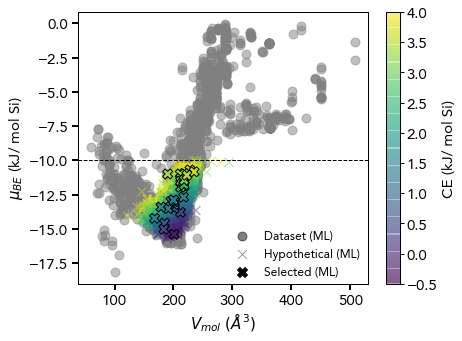

In [24]:
fig, axs = plt.subplots(figsize=(6.5, 5))
fw = 'CHA'

# background is project dataset 
y_bg = truth_mean[truth_mean['Zeolite'] == fw].set_index('SMILES')['BE (mean)']
y_bg = y_bg[y_bg.lt(0.0)] # only plot binding for clarity
x_bg = truth_opriors.loc[y_bg.index]['mol_volume']
kwargs = dict(marker='o', s=80, alpha=0.5, color='grey', label="Dataset (ML)", rasterized=True)
sc = axs.scatter(x_bg, y_bg, **kwargs)

# foreground is selected dataset 
y_fg = cha_all_mean[fw]
y_fg = y_fg[y_fg <= -10.0]
y_fg = y_fg[cha_all_comp.loc[y_fg.index][fw] <= 4.0] 
y_fg = y_fg.sort_values(ascending=False)
x_fg = cha_all_oprior.loc[y_fg.index]['mol_volume']
c = cha_all_comp.loc[y_fg.index][fw]
kwargs = dict(marker='x', s=80, alpha=0.4, c=c, label="Hypothetical (ML)", rasterized=True, vmin=-0.5, vmax=4, cmap='viridis')
sc = axs.scatter(x_fg, y_fg, **kwargs)

axs = format_axs(axs, 15, 15, 1, "$V_{mol} \; (\AA^3)$", "$\mu_{BE}$ (kJ/ mol Si)", 15, 15)
cb = get_cb(fig, sc, axs, "CE (kJ/ mol Si)", ticks=None, linewidth=1, tickwidth=1, labelsize=15, labelpad=20)

# horizontal line at -10
axs.axhline(-10, color='k', linestyle='--', linewidth=1, rasterized=True);

# plot ML for final pool of selected molecules
ee = cha_all_mean.reindex(ff_cha_mat.index)[fw]
cc = cha_all_comp.reindex(ff_cha_mat.index)[fw]
vv = cha_all_oprior.reindex(ff_cha_mat.index)['mol_volume']
axs.scatter(vv.values, ee.values, c=cc.values, marker='X', s=100, edgecolors='k', linewidth=1, label="Selected (ML)", vmin=-0.5, vmax=4, cmap='viridis')

leg = get_legend(fig, bbox_to_anchor=(0.75, 0.11), fontsize=12, loc="lower right", ncol=1, axs=axs, format_handles=True,legend_colors=['black']*6, linewidth=1)

save_mpl_fig(fig, figure_op_dir + "/be_vol_cha", ".pdf")
save_mpl_fig(fig, figure_op_dir + "/be_vol_cha", ".svg")